In [5]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import matplotlib
matplotlib.rcParams.update({'font.size': 32})
import matplotlib.pyplot as plt
import numpy
from pprint import pprint
from collections import defaultdict,OrderedDict
from datetime import datetime, timedelta
from functools import partial
import time
db = MongoClient('localhost').condor

In [2]:
db.condor_history.find_one({'EnteredCurrentStatus':{'$gte':time.mktime((2017,1,5,0,0,0,0,0,0)),
                                  '$lt':time.mktime((2017,2,14,0,0,0,0,0,0))},'Owner':'i3filter'})

{'AccountingGroup': 'ifThenElse(Requestgpus > 0,strcat("gpu.",Owner),undefined)',
 'BytesRecvd': 30431740.0,
 'BytesSent': 3202.0,
 'ClusterId': 32716528,
 'Cmd': '/scratch/i3filter/1900/iceprod_136.1484945774.635885/iceprod.1900.136.sh',
 'CommittedTime': 5,
 'CompletionDate': 1484946312,
 'CumulativeSlotTime': 5.0,
 'DiskUsage_RAW': 29723,
 'EnteredCurrentStatus': 1484946312,
 'ExecutableSize_RAW': 2,
 'ExitBySignal': False,
 'ExitCode': 5,
 'ExitStatus': 0,
 'GlobalJobId': 'sub-1.icecube.wisc.edu#32716528.0#1484945775',
 'ImageSize_RAW': 2,
 'JobCurrentStartDate': 1484946307,
 'JobStartDate': 1484946307,
 'JobStatus': 4,
 'LastJobStatus': 2,
 'LastRemoteHost': 'slot1@vv723.math.wisc.edu',
 'MATCH_EXP_JOBGLIDEIN_ResourceName': 'MATH_WISC',
 'NumJobStarts': 1,
 'NumShadowStarts': 1,
 'Owner': 'i3filter',
 'ProcId': 0,
 'QDate': 1484945775,
 'RemoteSysCpu': 0.0,
 'RemoteUserCpu': 0.0,
 'RemoteWallClockTime': 5.0,
 'RequestCpus': 1,
 'RequestDisk': 1000000,
 'RequestMemory': 4000,
 'Req

In [8]:
def timekey(t):
    return datetime.fromtimestamp(t).strftime('%Y-%m-%d')
def make2list():
    return [0.,0.]                              
def make3list():
    return [0.,0.,0]                     

In [23]:
projection = ['MATCH_EXP_JOBGLIDEIN_ResourceName','EnteredCurrentStatus',
              'RemoteWallClockTime','CumulativeSlotTime','NumJobStarts',
              'ExitCode','ExitBySignal','ExitSignal','JobStatus','LastJobStatus',
              'LastHoldReason',]
filter = {'EnteredCurrentStatus':{'$gte':time.mktime((2016,10,1,0,0,0,0,0,0)),
                                  '$lt':time.mktime((2017,3,1,0,0,0,0,0,0))},
          'Owner':'i3filter',
         # 'Requestgpus':1,
         }
# by day
good_completed = defaultdict(partial(defaultdict,make2list))
bad_completed = defaultdict(partial(defaultdict,make2list))
bad_removed_run = defaultdict(partial(defaultdict,make2list))
bad_removed_hold_memory = defaultdict(partial(defaultdict,make2list))
bad_removed_hold_transfer = defaultdict(partial(defaultdict,make2list))
bad_removed_hold = defaultdict(partial(defaultdict,make2list))
bad_removed_other = defaultdict(partial(defaultdict,make2list))
bad_signal = defaultdict(partial(defaultdict,make2list))
bad_signal_glidein = defaultdict(partial(defaultdict,make2list))
bad_signal_user = defaultdict(partial(defaultdict,make2list))
bad_restarts = defaultdict(make3list)
no_restarts = defaultdict(partial(defaultdict,int))
start_time = time.time()
for i,row in enumerate(db.condor_history.find(filter=filter,projection=projection)):
    try:
        if 'MATCH_EXP_JOBGLIDEIN_ResourceName' not in row:
            continue
        site = row['MATCH_EXP_JOBGLIDEIN_ResourceName']
        date = timekey(row['EnteredCurrentStatus'])
        if not row['ExitBySignal']:
            if row['JobStatus'] == 4:
                if row['ExitCode'] == 0:
                    good_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    good_completed[site][date][1] += 1
                else:
                    bad_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_completed[site][date][1] += 1
            elif row['JobStatus'] == 3:
                if row['LastJobStatus'] == 2:
                    bad_removed_run[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_run[site][date][1] += 1
                elif row['LastJobStatus'] == 5:
                    if 'LastHoldReason' in row and 'memory' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_memory[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_memory[site][date][1] += 1
                    elif 'LastHoldReason' in row and 'failed to receive' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_transfer[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_transfer[site][date][1] += 1
                    else:
                        bad_removed_hold[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold[site][date][1] += 1
                else:
                    bad_removed_other[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_other[site][date][1] += 1
        else:
            if row['ExitSignal'] in (6,11,7,8):
                bad_signal_user[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_user[site][date][1] += 1
            elif row['ExitSignal'] in (12,9,15):
                bad_signal_glidein[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_glidein[site][date][1] += 1
            else:
                bad_signal[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal[site][date][1] += 1
        
        if row['NumJobStarts'] > 1:
            bad_restarts[date][0] += float(row['CumulativeSlotTime'])-float(row['RemoteWallClockTime'])
            bad_restarts[date][1] += 1
            bad_restarts[date][2] += int(row['NumJobStarts'])
        else:
            no_restarts[site][date] += 1
    except:
        print(row)
        raise
print(time.time()-start_time)

103.19270372390747


In [24]:
bad_all = defaultdict(partial(defaultdict,make2list))
bad_by_type = defaultdict(partial(defaultdict,make2list))
bad_categories = OrderedDict([
        ('Completed - Exit != 0', bad_completed),
        ('Removed', bad_removed_run),
        ('Hold Memory', bad_removed_hold_memory),
        ('Hold Transfer', bad_removed_hold_transfer),
        ('Hold Other', bad_removed_hold),
        ('Removed Other', bad_removed_other),
        ('User SIGSEGV', bad_signal_user),
        ('Glidein Walltime', bad_signal_glidein),
        ('Signal Other', bad_signal),
])
for name,cat in bad_categories.items():
    for k in cat:
        for d in cat[k]:
            bad_all[k][d][0] += cat[k][d][0]
            bad_all[k][d][1] += cat[k][d][1]
            bad_by_type[name][d][0] += cat[k][d][0]
            bad_by_type[name][d][0] += cat[k][d][1]

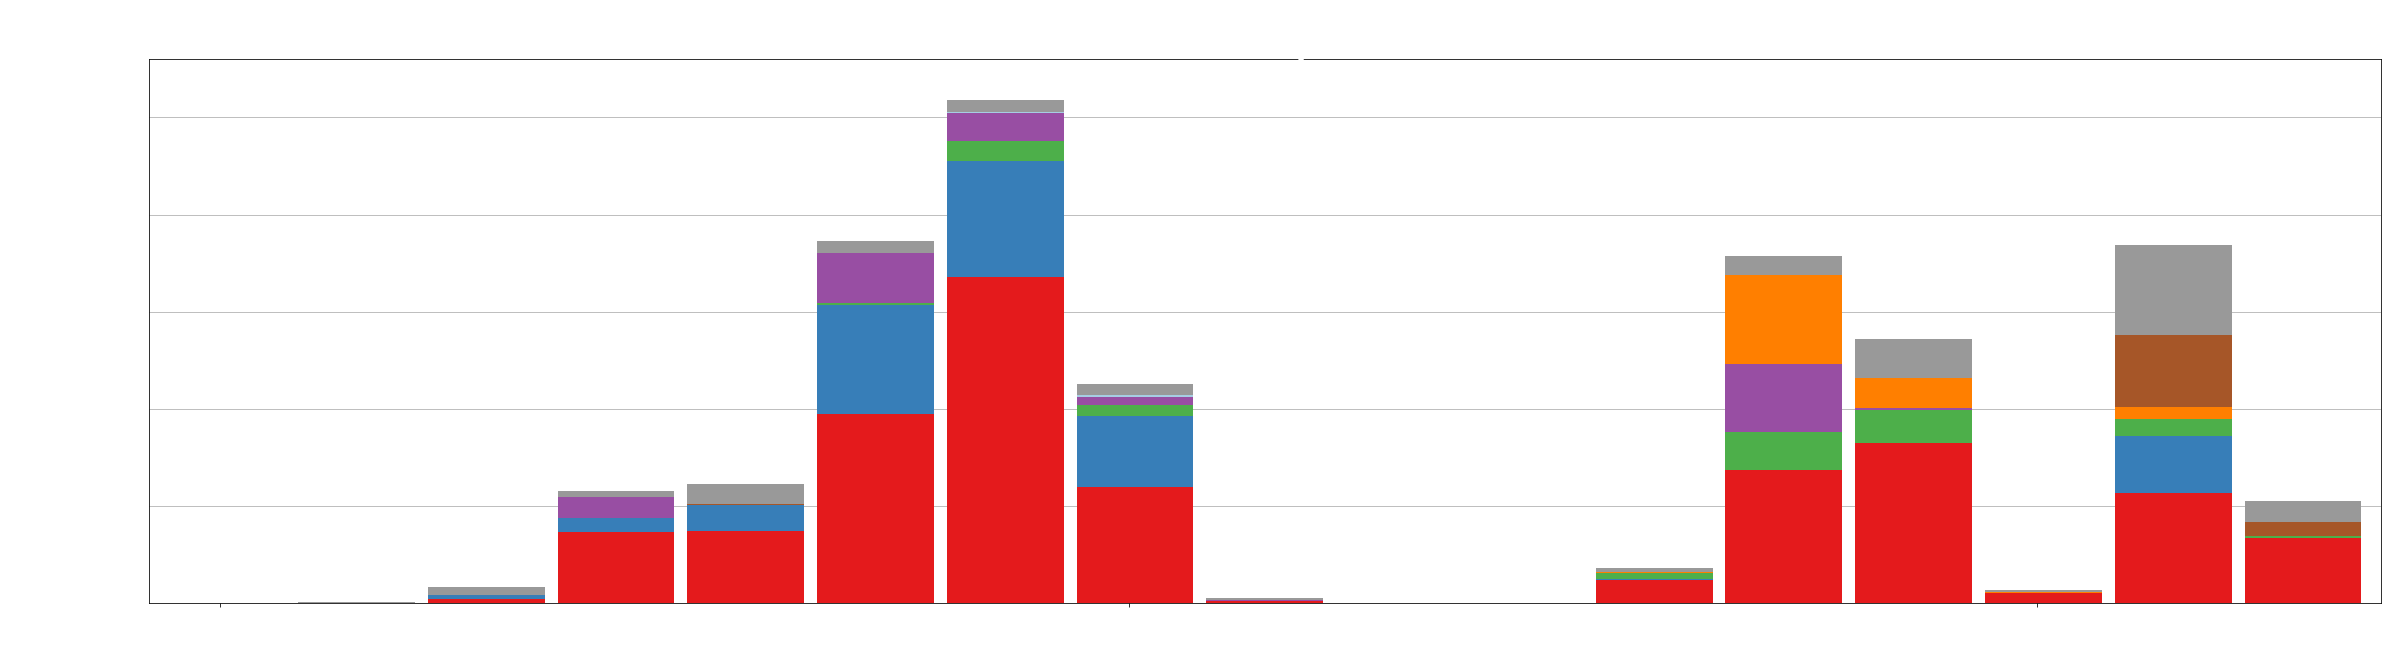

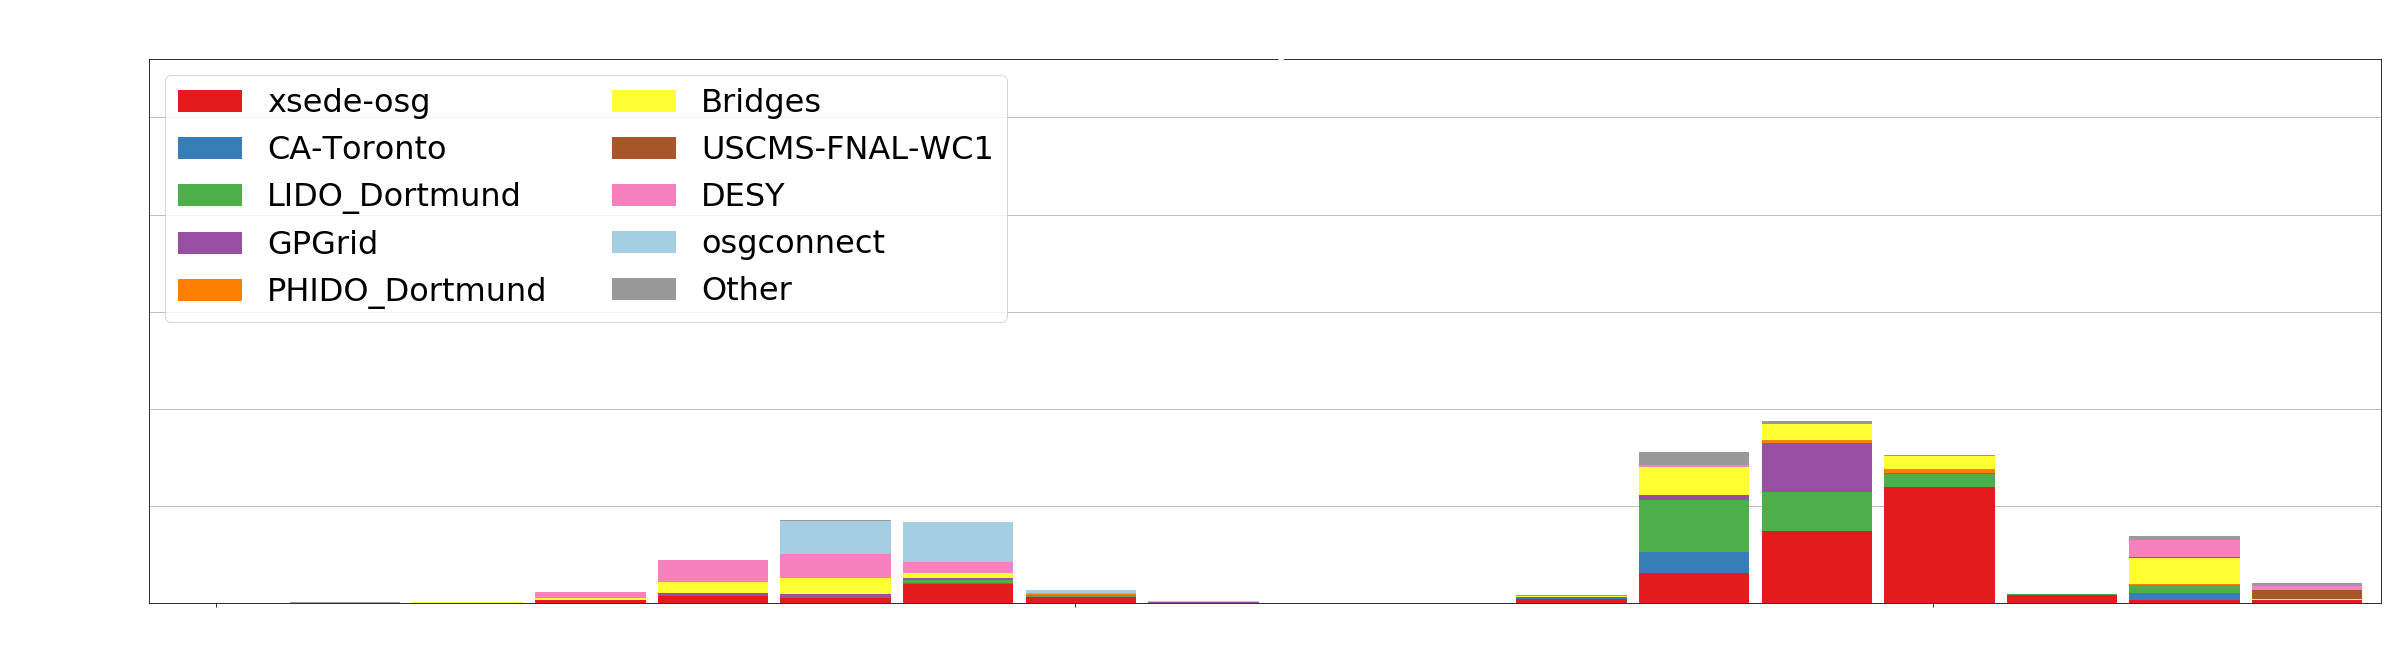

In [25]:
categories = OrderedDict([
    ('Goodput', good_completed),
    ('Badput', bad_all),
])
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#a6cee3','#999999','#fb9a99',]
all_time_sites = defaultdict(float)
for category in categories.values():
    for k,new_k in [('CA-MCGILL-CLUMEQ-T2','Guillimin'),
                    ('parallel','Alberta'),
                    ('Crane','Nebraska'),
                    ('Guillimin','CA-Toronto'),
                    ('mainz','Mainz')]:
        for d in category[k]:
            category[new_k][d][0] += category[k][d][0]
            category[new_k][d][1] += category[k][d][1]
        del category[k]
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = sorted(all_time_sites,key=lambda k:all_time_sites[k],reverse=True)[:9]+['Other']
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600/24 for d in x]) for k in category}
    #pprint(y.keys())
    other = numpy.sum([y[k] for k in y if k not in top10], axis=0)

    legend = [k for k in top10 if k in y]
    if other.any():
        legend.append('Other')
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    ax.set_title(title,color='white',fontsize=60)
    ax.set_xticks(xx[::7]-.05)
    ax.set_xticklabels(x[::7], color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('CPUdays', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    #labels = ax.get_xticklabels()
    #plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    plt.ylim([0,2800])
    if title != 'Goodput':
        plt.legend(plots, legend, loc='upper left', ncol=2)

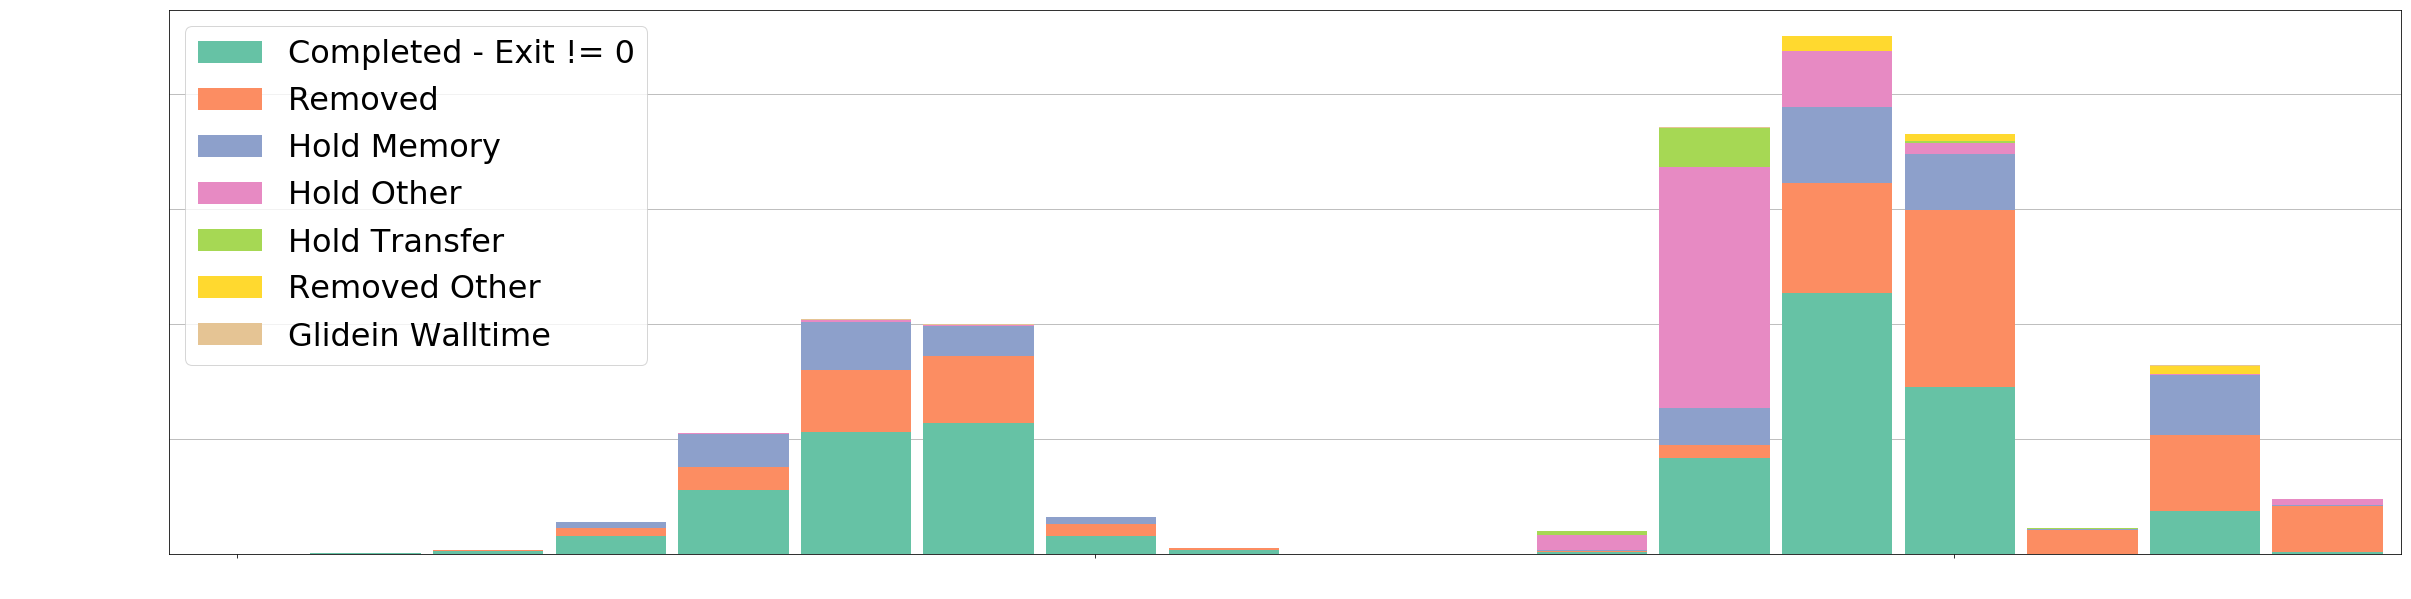

In [26]:
categories = OrderedDict([
    ('Bad by type', bad_by_type),
])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
all_time_sites = defaultdict(float)
for category in categories.values():
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = sorted(all_time_sites,key=lambda k:all_time_sites[k],reverse=True)[:9]
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600 for d in x]) for k in category}

    legend = [k for k in top10 if k in y]
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    #ax.set_title(title,color='white')
    ax.set_xticks(xx[::7]-.05)
    ax.set_xticklabels(x[::7], color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('CPUhours', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    #labels = ax.get_xticklabels()
    #plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    #plt.ylim([0,80000])
    plt.legend(plots, legend, loc='upper left')